In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

print("done")

done


In [2]:
import import_func as imp
import tags_work as tgs
import desc_vis as vis
import classifier_help as clh

def output_plot(outfile):
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(outfile, dpi=100, bbox_inches='tight')

In [3]:
full_filename = "../data/by_article_fulltext_020920.jl"

full_df = imp.init_df(full_filename, "full", categories="all")

full_df = full_df.drop(
    [
        "date",
        "time",
        "date_seq",
        "column1",
        "column2",
        "one_time",
        "bio",
    ],
    axis=1,
)


print("done")

categories = [
    "advice",
    "job market",
    "academic",
    "postdoc",
    "graduate",
    "workplace diversity",
    "midcareer",
    "non-disciplinary",
    "life and career balance",
    "industry",
    "career profiles",
    "government",
    "undergraduate",
    "working life",
    "early career",
    "career-related policy"
        ]

formal_labels = {}
        
new_categories = []
for cat in categories:
    cat_new = cat.replace(" ", "_").replace("-", "_")
    cat = cat[0].upper() + cat[1:]
    formal_labels[cat_new] = cat
    new_categories.append(cat_new)
categories = new_categories

plots = ["modals","first","second","hedges","boosters"]

word_type_labels = {
    "modals":"Modal verbs",
    "first":"First person pronouns",
    "second":"Second person pronouns",
    "hedges":"Hedges",
    "boosters":"Boosters"
    }

# print(categories)

done


In [12]:
def loess_month_plot(full_df, categories, function):

    count=0
    pieces={}
    used_cat = []

    plt.figure(figsize=(12, 8))

    if function in ["first", "second"]:
        counts_df = clh.pronouns(full_df)
    elif function == "modals":
        counts_df = clh.modals(full_df)
    elif function == "hedges":
        counts_df = clh.hedges(full_df, hedges="hedges")
    elif function == "boosters":
        counts_df = clh.hedges(full_df,hedges="boosters")
    else:
        print("acceptable function arguments are: first, second, modals, hedges, boosters")

    # remove data points that have been derived from fewer than 5 articles

    removals = []
    start_month = min(counts_df.month_seq)
    end_month = max(counts_df.month_seq)

    # print(start_year, end_year)

    for i in range(start_month,end_month):
        if len(counts_df[counts_df.month_seq == i]) < 3:
            # print(cat, i)
            removals.append(i)
    # print(len(counts_df))
    counts_df = counts_df[~counts_df["month_seq"].isin(removals)]
    # print(len(counts_df))

    counts_df = counts_df.groupby("month_seq").median()

    counts_df["inc1"] = counts_df[function]/counts_df["wc"]
    counts_df[function] = counts_df["inc1"]
    
    counts_plot_df = counts_df.reset_index()
    pieces["all"] = counts_plot_df
    used_cat.append("all")

    ### same thing for categories ###

    for cat in categories:
        cat_df = full_df[full_df[cat] == "yes"]
            # print(categories[count])
        # counts_df = clh.pronouns(cat_df)
        if function in ["first", "second"]:
            counts_df = clh.pronouns(cat_df)
        elif function == "modals":
            counts_df = clh.modals(cat_df)
        elif function == "hedges":
            counts_df = clh.hedges(cat_df, hedges="hedges")
        elif function == "boosters":
            counts_df = clh.hedges(cat_df,hedges="boosters")
        else:
            print("acceptable function arguments are: first, second, modals, hedges, boosters")
        
        # remove data points that have been derived from fewer than 5 articles

        removals = []
        start_month = min(counts_df.month_seq)
        end_month = max(counts_df.month_seq)

        # print(start_year, end_year)

        for i in range(start_month,end_month):
            if len(counts_df[counts_df.month_seq == i]) < 3:
                # print(cat, i)
                removals.append(i)
        # print(len(counts_df))
        counts_df = counts_df[~counts_df["month_seq"].isin(removals)]
        # print(len(counts_df))

        if  (end_month-start_month) - len(removals) < (end_month-start_month)/2 or cat == "working_life":
            # print(cat)
            # print(removals)
            continue 

        counts_df = counts_df.groupby("month_seq").mean()

        counts_df["inc1"] = counts_df[function]/counts_df["wc"]
        counts_df[function] = counts_df["inc1"]
        
        counts_plot_df = counts_df.reset_index()
        # pieces.append(counts_plot_df)
        pieces[cat] = counts_plot_df

        # sns.lmplot(x = "year", y = "frac1",lowess=True, data = counts_plot_df)
        # plt.title("first person "+categories[count])

        used_cat.append(cat)
        count+=1

    return(pieces)


def position(item):
    j=1
    if item =="modals":
        i=0
    elif item == "first" or item == "second":
        i=1
        if item == "first":
            j=0
    else:
        i=2
        if item == "boosters":
            j=0
    return(i,j)

1 0
0 1
1 1
1 2
0 2


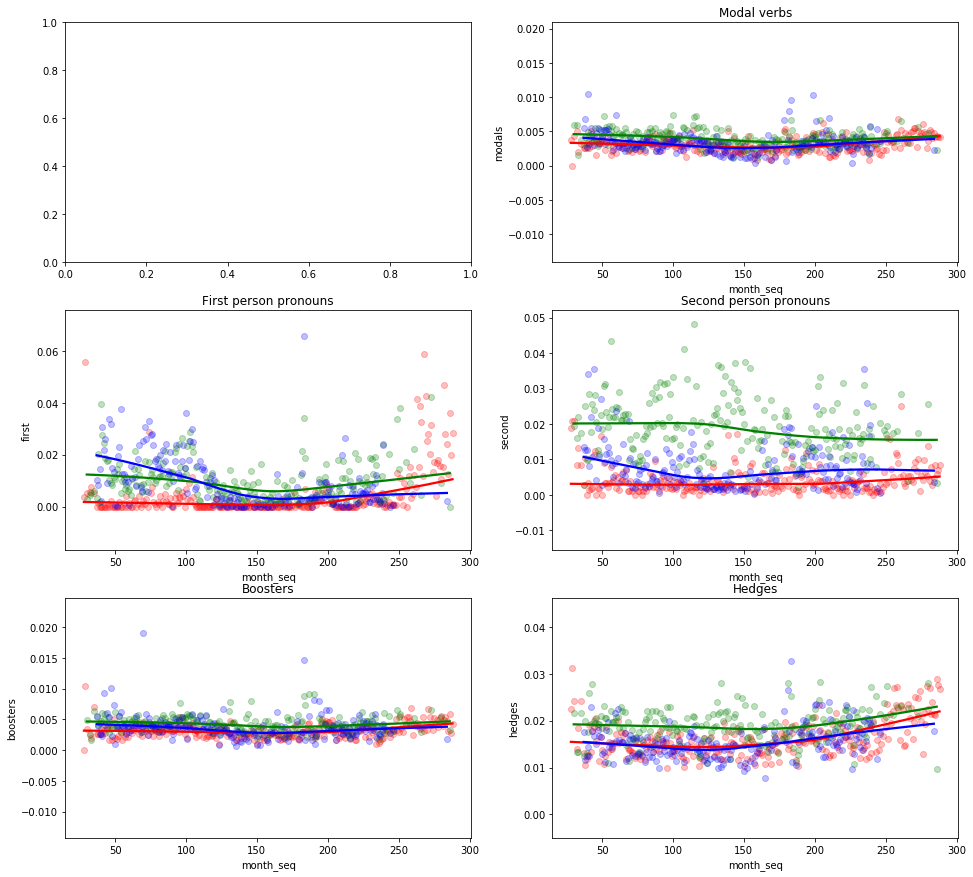

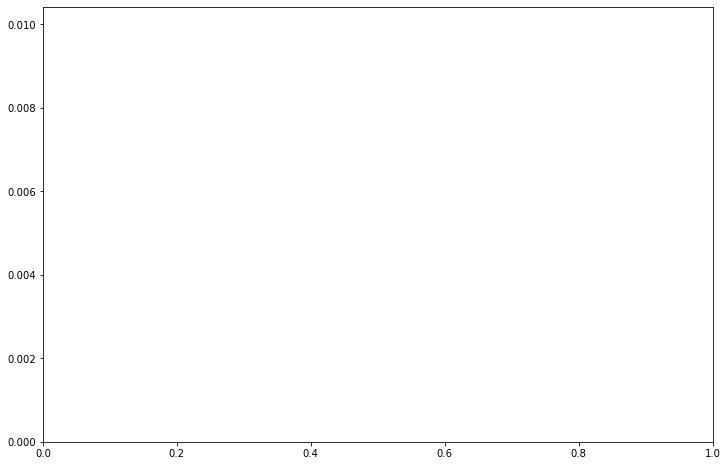

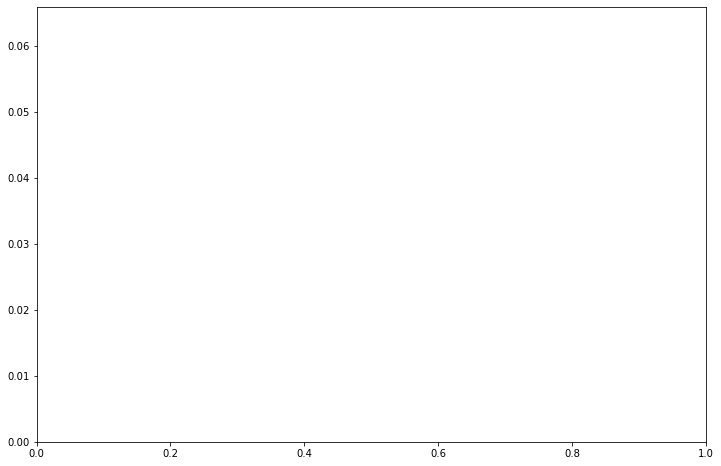

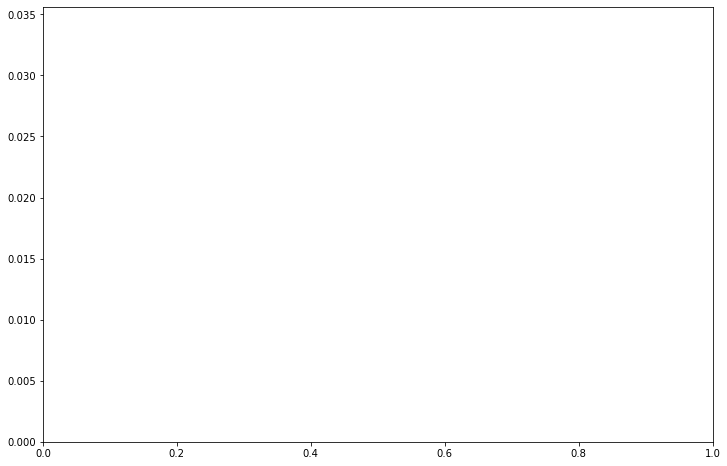

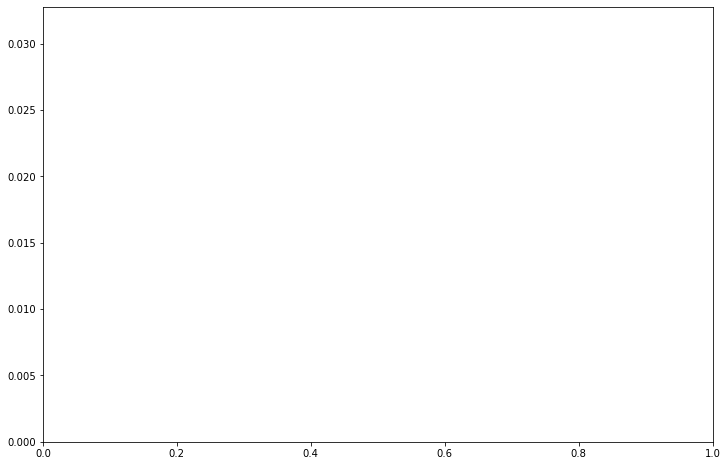

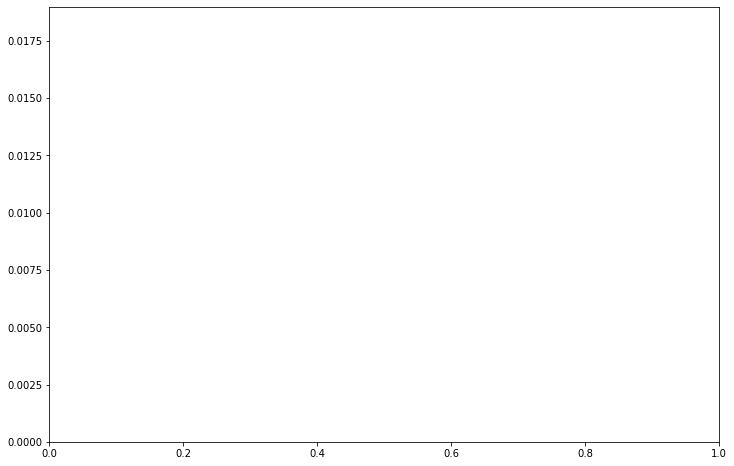

In [19]:
fig, axs = plt.subplots(3,2)
# fig.suptitle('Vertically stacked subplots')
# fig.figure(figsize=(12, 8))
fig.set_figheight(15)
fig.set_figwidth(13)

color_dict = dict({'all':'red',
                  'advice':'green',
                  'job_market': 'blue'
                  })

for item in plots:
# for item in ["first"]:

    pieces = loess_month_plot(full_df=full_df, categories=categories, function=item)
    i,j = position(item)
    print(j,i)

    for key in pieces:
        # print(key)
        # print(color_dict[key])
        df = pieces[key]
        sns.regplot(x = "month_seq", y = item,
        lowess=True,
        scatter_kws={'alpha':0.25},
        color=color_dict[key],
        label = key,
        ax=axs[i,j],
        data = df)
        # plt.axhline(y=all_overall, color="gray")
        plt.ylim([0,max(df["inc1"])])

        axs[i,j].set_title(word_type_labels[item])

